<a href="https://colab.research.google.com/github/SheidaAbedpour/Plant-Leaf-Classification/blob/main/leaf_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import os
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from skimage.feature import local_binary_pattern, hog
from skimage.filters import gabor

import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Images

In [2]:
def preprocess_image(image_path, output_path, size=(256, 256)):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Remove noise using GaussianBlur
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Resize the image
    resized_image = cv2.resize(blurred_image, size)

    # Save the processed image
    cv2.imwrite(output_path, resized_image)


In [3]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/leaf-classification/leaves'
output_dir = '/content/drive/MyDrive/Colab Notebooks/leaf-classification/leaves-processed'
os.makedirs(output_dir, exist_ok=True)


for folder_name in os.listdir(root_dir):
  folder_path = os.path.join(root_dir, folder_name)

  if os.path.isdir(folder_path):
    output_folder_path = os.path.join(output_dir, folder_name)
    os.makedirs(output_folder_path, exist_ok=True)

    for img_name in os.listdir(folder_path):
      img_path = os.path.join(folder_path, img_name)
      output_img_path = os.path.join(output_folder_path, img_name)
      # process and save the image
      preprocess_image(img_path, output_img_path)


# Feature Extraction

In [2]:
def extract_lbp_features(image):
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist


def extract_hog_features(image):
    features, _ = hog(image, orientations=9, pixels_per_cell=(16, 16),
                      cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return features


def extract_orb_features(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((64,))
    return descriptors.flatten()[:64]


def extract_gabor_features(image):
    filters = []
    num_scales = 5
    num_orientations = 8
    for theta in np.arange(0, np.pi, np.pi / num_orientations):
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernel = cv2.getGaborKernel((21, 21), sigma, theta, frequency, 0.5, 0, ktype=cv2.CV_32F)
                filters.append(kernel)

    features = []
    for kernel in filters:
        fimg = cv2.filter2D(image, cv2.CV_8UC3, kernel)
        features.extend(fimg.ravel())

    return np.array(features[:128])


In [4]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/leaf-classification/leaves-processed'

features_list = []
folder_index = 0

for folder_name in os.listdir(root_dir):
  folder_index += 1
  folder_path = os.path.join(root_dir, folder_name)

  if os.path.isdir(folder_path):
    image_index = 0

    for img_name in os.listdir(folder_path):
      image_index += 1
      img_path = os.path.join(folder_path, img_name)
      image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

      lbf_features = extract_lbp_features(image)
      hog_features = extract_hog_features(image)
      #orb_features = extract_orb_features(image)
      #gabor_features = extract_gabor_features(image)

      extracted_features = np.concatenate([lbf_features, hog_features])
      features_list.append([folder_index, image_index] + extracted_features.tolist())



output_csv_path = '/content/drive/MyDrive/Colab Notebooks/leaf-classification/features.csv'
features_df = pd.DataFrame(features_list)
features_df.to_csv(output_csv_path, index=False)


In [5]:
print(features_df.shape)
features_df.head()

(443, 8111)


,0,1,2,3,4,5,6,7,8,9,...,8101,8102,8103,8104,8105,8106,8107,8108,8109,8110
0,1,1,0.020538,0.068832,0.022583,0.104324,0.109726,0.174591,0.107117,0.097046,...,0.113195,0.229852,0.064980,0.065598,0.143267,0.229852,0.203198,0.202729,0.057279,0.068118
1,1,2,0.027725,0.079773,0.032181,0.103241,0.107132,0.151291,0.112457,0.098572,...,0.118712,0.214563,0.084731,0.161559,0.168356,0.214563,0.199051,0.144328,0.081321,0.039529
2,1,3,0.019913,0.071503,0.021408,0.100754,0.101318,0.175217,0.103973,0.099701,...,0.008018,0.200710,0.022678,0.158478,0.156798,0.230509,0.133093,0.101094,0.089969,0.016035
3,1,4,0.035248,0.087250,0.041489,0.100189,0.114716,0.138092,0.107025,0.098358,...,0.062605,0.214356,0.192970,0.150780,0.162091,0.207241,0.207771,0.127317,0.121839,0.062577
4,1,5,0.024963,0.082733,0.028976,0.094101,0.119843,0.159927,0.098801,0.101669,...,0.012635,0.187799,0.086104,0.102576,0.198514,0.231088,0.231088,0.185028,0.106626,0.051371


In [6]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/leaf-classification/leaves.csv')
df_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/leaf-classification/features.csv')

df_features.columns.values[0] = '1'
df_features.columns.values[1] = '1.1'

df_merged = pd.merge(df_main, df_features, on=['1', '1.1'])

In [7]:
df_merged

,1,1.1,0.72694,1.4742,0.32396,0.98535,1.2,0.83592,0.0046566,0.0039465,...,8101,8102,8103,8104,8105,8106,8107,8108,8109,8110
0,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,...,0.118712,0.214563,0.084731,0.161559,0.168356,0.214563,0.199051,0.144328,0.081321,0.039529
1,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,...,0.008018,0.200710,0.022678,0.158478,0.156798,0.230509,0.133093,0.101094,0.089969,0.016035
2,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,...,0.062605,0.214356,0.192970,0.150780,0.162091,0.207241,0.207771,0.127317,0.121839,0.062577
3,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,...,0.012635,0.187799,0.086104,0.102576,0.198514,0.231088,0.231088,0.185028,0.106626,0.051371
4,1,6,0.72997,1.4892,0.34284,0.98755,1.00000,0.844820,0.004945,0.004451,...,0.054677,0.229000,0.059784,0.159690,0.170883,0.229000,0.197991,0.174899,0.157707,0.075639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,...,0.022380,0.215481,0.103017,0.125554,0.215481,0.215481,0.198307,0.199821,0.124882,0.014920
303,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,...,0.087430,0.216148,0.069405,0.126475,0.109320,0.216148,0.216148,0.216148,0.108129,0.110355
304,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,...,0.138484,0.227714,0.091491,0.148124,0.089949,0.227714,0.202591,0.223720,0.067558,0.044418
305,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,...,0.024884,0.215305,0.116264,0.214473,0.213886,0.209298,0.212195,0.186204,0.104681,0.056591


In [9]:
df_x = df_merged.drop(['1', '1.1'], axis='columns')
df_label = df_merged['1']

In [10]:
print(df_x.shape)
print(df_label.shape)

(307, 8123)
(307,)


# Dataset PreProcessing

In [79]:
df_x = df_main.drop(['1', '1.1'], axis='columns')
df_label = df_main['1']

x_train, x_test, y_train, y_test = train_test_split(df_x, df_label, test_size=0.2, shuffle=True, random_state=42)
x_train, y_train = x_train.to_numpy(), y_train.to_numpy()
x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

# Scale
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Apply PCA
pca = PCA(n_components=13)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [80]:
print(x_train.shape, type(x_train))
print(x_test.shape, type(x_test))
print(y_train.shape, type(y_train))
print(y_test.shape, type(y_test))

(271, 13) <class 'numpy.ndarray'>
(68, 13) <class 'numpy.ndarray'>
(271,) <class 'numpy.ndarray'>
(68,) <class 'numpy.ndarray'>


In [96]:
# Define classifiers
classifiers = {
    'SVM': SVC(C=1.0, kernel='rbf', gamma='scale', degree=3),
    'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=10),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Adaboost': AdaBoostClassifier(n_estimators=100),
    'Naive Bayes': GaussianNB(),
    'MLP Classifier': MLPClassifier(hidden_layer_sizes=(32), max_iter=1000, random_state=42)
}


results = []
conf_matrices = {}
classification_reports = {}
# Function to evaluate and collect performance
def evaluate_model(name, model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    results.append({
        'Classifier': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    conf_matrices[name] = conf_matrix

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(x_train, y_train)
    evaluate_model(name, clf, x_test, y_test)

results_df = pd.DataFrame(results)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

In [97]:
results_df.sort_values(by='F1 Score', ascending=False, ignore_index=True)

,Classifier,Accuracy,Precision,Recall,F1 Score
0,MLP Classifier,0.941176,0.973039,0.941176,0.946732
1,Logistic Regression,0.926471,0.953922,0.926471,0.927638
2,Random Forest,0.867647,0.931863,0.867647,0.875747
3,Naive Bayes,0.808824,0.862745,0.808824,0.805952
4,SVM,0.735294,0.778711,0.735294,0.717291
5,K-Nearest Neighbors,0.602941,0.640844,0.602941,0.575624
6,Decision Tree,0.588235,0.619363,0.588235,0.568627
7,Adaboost,0.205882,0.182010,0.205882,0.169960


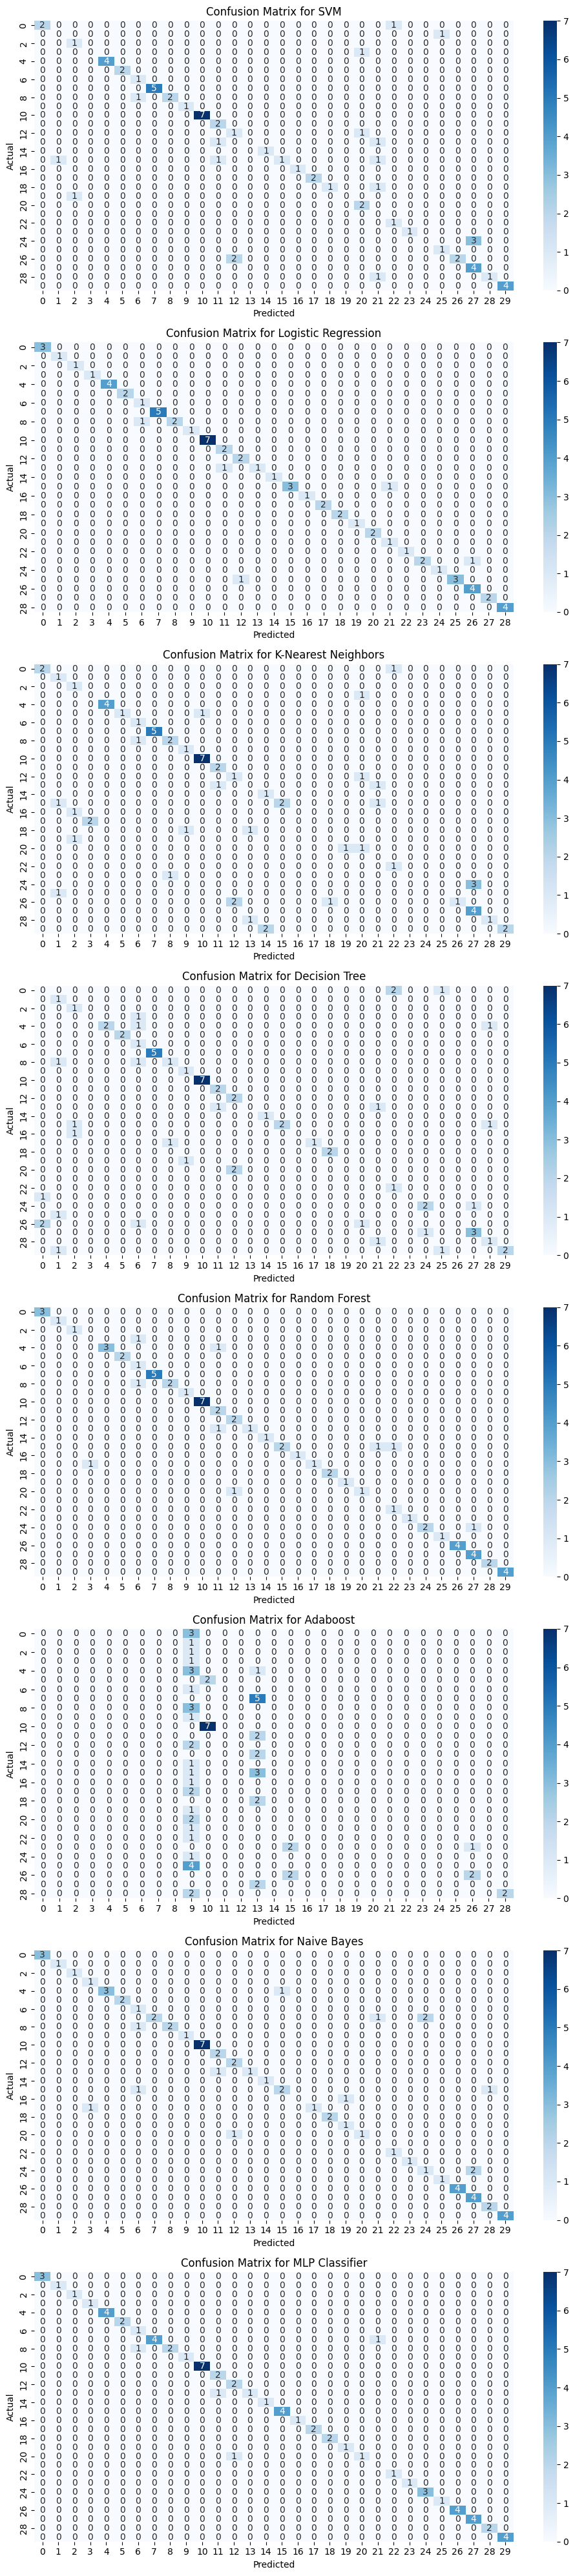

In [98]:

fig, axes = plt.subplots(len(classifiers), 1, figsize=(10, len(classifiers) * 5))

for i, (name, conf_matrix) in enumerate(conf_matrices.items()):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()